## ExMAS
> Equilibrium matching


In [1]:
import os
import math
import netwulf as nw
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching
from ExMAS.extras import games, pricings, prunings, pipeline

In [4]:
netwufl_config_path = os.path.join(os.getcwd(),'spinoff/game/netwulf_config.json')

In [5]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/pipe.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
params.nP = 300
params.simTime = 0.3
params.shared_discount = 0.2
inData = ExMAS.utils.generate_demand(inData, params)  # generate requests

In [6]:
inData = ExMAS.main(inData, params, plot = False)
KPIs = inData.sblts.res.to_frame('u_pax')
inData = games.prepare_PoA(inData)  # prepare data structures

### pricing

eq. 1 , eq.2

In [7]:

params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0 # fixed penalty (EUR) per 

params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0.5 # ride fixed costs (per vehicle)

In [8]:
inData = pricings.update_costs(inData, params)

In [9]:
inData = pricings.uniform_split(inData) 

In [10]:
_, config, _ = nw.load("netwulf_config.json") # load config
_, config_schedule, _ = nw.load("netwulf_config_schedule.json") # load config

### ExMAS 


two graphs for each algorithm: 
* first shareability potential groups
* then assignment, ILP solution for BPoA

nodes are travellers, links if they form a group, size is the degree (number of rides in which you may participate)

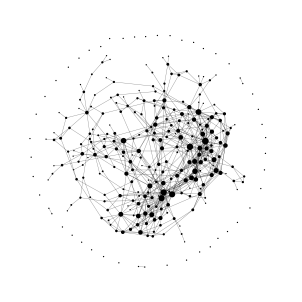

In [11]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.rides)
#stylized_network, config = nw.visualize(G)  # create config
# nw.save("netwulf_config.json", stylized_network, config) # save config
_, _ = nw.visualize(G, config = config)

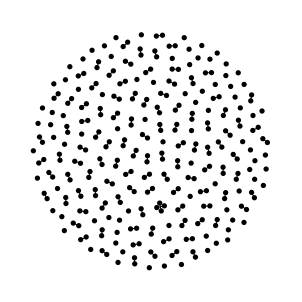

In [12]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
#stylized_network, config_schedule = nw.visualize(G)  # create config
#nw.save("netwulf_config_schedule.json", stylized_network, config_schedule) # save config
_, _ = nw.visualize(G, config = config_schedule)

### TNE 


16-12-20 10:59:44-WARNING-Prunings:  ['TNE']
16-12-20 10:59:44-WARNING-Pruned nRides 467/1029
16-12-20 10:59:44-WARNING-Mutually exclusives 0
16-12-20 10:59:44-WARNING-UNIFORM-['UNIFORM']-['TNE']-UNIFORM-min


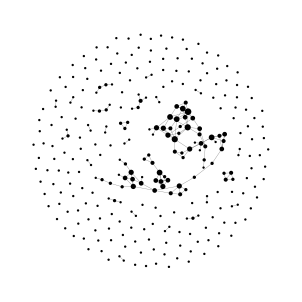

In [13]:
params.multi_platform_matching = True
params.assign_ride_platforms = False
inData = prunings.algo_TNE(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['TNE'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoA
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.rides[inData.sblts.rides.pruned])
_, _ = nw.visualize(G, config = config)

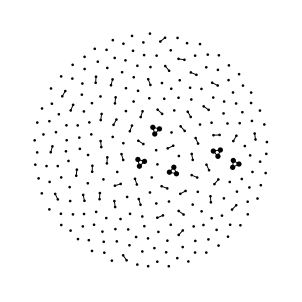

In [14]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
_, _ = nw.visualize(G, config = config_schedule)

16-12-20 11:00:04-WARNING-Prunings:  ['HERMETIC']
16-12-20 11:00:04-WARNING-Pruned nRides 441/1029
16-12-20 11:00:04-WARNING-Mutually exclusives 0
16-12-20 11:00:04-WARNING-UNIFORM-['UNIFORM']-['HERMETIC']-UNIFORM-min


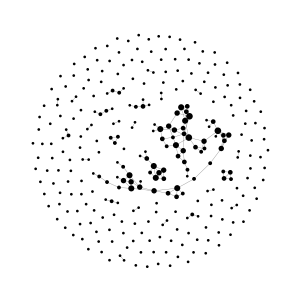

In [15]:
params.multi_platform_matching = True
params.assign_ride_platforms = False
inData = prunings.algo_HERMETIC(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['HERMETIC'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoA
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.rides[inData.sblts.rides.pruned])
_, _ = nw.visualize(G, config = config)

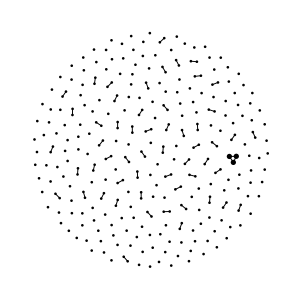

In [16]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
_, _ = nw.visualize(G, config = config_schedule)

---
(c) Rafał Kucharski, Delft, 2020